# Topic 8: Simulating bias for testing mitigation models and fairness

The project aims to simulate bias in data and evaluate how machine learning models trained on biased data behave. Additionally, it will assess different methods to mitigate bias and improve the fairness of the model’s predictions. The main focus is to understand the impact of biased data on a machine learning system and how fairness interventions affect outcomes.


## Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings('ignore')

## Bias In Data


### Bias in Data and its Simulation

In machine learning (ML), bias refers to systematic errors in data that can lead to unfair decisions. Simulating bias involves generating synthetic datasets that replicate these errors, allowing researchers to analyze the impact of bias on model performance and fairness. Through these simulations, researchers can develop methods to mitigate bias, ensuring fairness and accuracy in decision-making processes.

Bias can appear at various stages of the ML pipeline, from data collection to model deployment. If left unchecked, these biases can perpetuate societal inequalities. Simulating bias helps explore its consequences in controlled scenarios, providing insights into how different types of bias affect both fairness and model accuracy.

### Four Fundamental Types of Bias
1. **Historical Bias**: This type of bias occurs when societal inequalities are reflected in the data. For example, differences in income between genders can reflect past injustices, embedding unfair patterns in the data.
2. **Measurement Bias**: Arises when a proxy variable, instead of the true value, is used in decision-making. For example, using IQ tests as a proxy for intelligence may introduce bias if the tests favor certain groups.
3. **Representation Bias**: Happens when a specific subgroup (e.g., based on ethnicity or gender) is underrepresented or misrepresented in the data, leading to biased outcomes.
4. **Omitted Variable Bias**: Occurs when an important variable is omitted, resulting in a model that depends on other variables, potentially correlating with sensitive attributes.

### Mathematical Explanation of Bias

We model the relationships between variables and simulate bias using the following equations:

- Let X represent the feature set, and Y be the target variable. The relationship between these variables can be expressed as: Y = f(X) + ε
  where f(X) is the function describing the relationship between features and the target, and ε represents noise.

Different types of bias affect this system in various ways:

- **Historical Bias**: Occurs when a sensitive attribute A impacts both the features X and the target Y. For example: X = g(X) - βh A where βh is the parameter that determines the strength of historical bias.

- **Measurement Bias**: When proxies \( Px \) and \( Py \) are observed instead of true values X and Y, and these proxies are affected by sensitive attributes:
  \[
  Px = X - βm A + N_Px
  \]
  Here, βm is the measurement bias parameter, and N_Px represents random noise affecting the proxy variable.

- **Representation Bias**: This bias can be modeled by undersampling a subgroup of individuals with a sensitive attribute A = 1. The proportion of the undersampled group can be represented as Pu, the undersampling parameter.

- **Omitted Variable Bias**: This occurs when an important feature is missing. For instance, omitting R from the model and using only X could result in spurious dependencies on the sensitive attribute A.

By adjusting the parameters βh, βm, and Pu, we can simulate various types of bias and examine their effects on fairness and model performance.


## Bias Simulation

In [2]:
def create_synth(var_config):

    dim = var_config.get('dim')

    thr_supp = 1  # Threshold correlation for discarding features too correlated with sensitive attributes

    task_type = var_config.get('task_type', 'classification')
    num_classes = var_config.get('num_classes', 2)  # Default to binary classification

    sy = 1  # Standard deviation of the noise of Y

    # Values to generate R (Primary Variable)
    R_config = var_config.get('R', [{}])[0]
    R_mean = R_config.get('mean', 0)  # Default mean is 0 if not found
    R_std = R_config.get('std', 1)  # Default std is 1 if not found
    R_func = R_config.get('func', 'normal')  # Default function is normal if not found

    if R_func == 'normal':
        R = np.random.normal(R_mean, R_std, dim)
    elif R_func == 'uniform':
        R = np.random.uniform(R_mean, R_std, dim)
    elif R_func == 'binomial':
        R = np.random.binomial(R_mean, R_std, dim)

    # Remap R to fit the min and max values defined in the config
    r_max = R_config.get('max', 1)
    r_min = R_config.get('min', 0)
    R = (R - R.min()) / (R.max() - R.min())
    R = R * (r_max - r_min) + r_min

    # Create y_real as a direct, unbiased transformation of R
    y_real = R.copy()

    # Create variable A (sensitive attributes)
    A_vars = {}
    for var in var_config.get('A', []):
        A_vars[var['name']] = np.random.normal(0, 3, dim)
        if var['binary']:
            A_vars[var['name']] = np.random.binomial(1, 0.5, dim)
        else:
            A_vars[var['name']] = np.random.normal(0, 3, dim)

    # Modify R based on historical bias from A
    N1 = R.copy()
    for var in var_config.get('A', []):
        A_var = A_vars[var['name']]
        hist_bias_factor = np.tanh(var['hist_bias'])  # Amplify bias using non-linear scaling
        N1 -= hist_bias_factor * A_var

    # Create variable Q (auxiliary features)
    Q_vars = {}
    for var in var_config.get('Q', []):
        Q_func = var.get('func', 'normal')
        if Q_func == 'normal':
            Q_vars[var['name']] = np.random.normal(0, 3, dim)
        elif Q_func == 'uniform':
            Q_vars[var['name']] = np.random.uniform(0, 3, dim)
        elif Q_func == 'binomial':
            Q_vars[var['name']] = np.random.binomial(1, 0.5, dim)

    y = N1.copy()

    for var in var_config.get('Q', []):
        Q_var = Q_vars[var['name']]
        Q_importance = var['importance']
        
        # Scale the influence of Q by its importance
        y += Q_importance * Q_var

    # Generate y with all biases applied
    for var in var_config.get('A', []):
        A_var = A_vars[var['name']]
        A_hist_bias = var['hist_bias']  # No need for np.tanh() if we want linear scaling

        # Control influence of A based on hist_bias
        A_meas_bias = var['meas_bias'] * (np.abs(N1 - np.median(N1)) / np.std(N1))  # Scaled to standard deviation
        
        # When hist_bias = 0, A has no influence on y, and when hist_bias = 1, A has maximum influence
        hist_bias_factor = 1 + A_hist_bias * 10  # Multiply by a scaling factor to exaggerate the effect
        
        # Apply multiplicative influence of A on y
        y *= 1 + (hist_bias_factor * A_var * A_meas_bias * (N1 < np.median(N1)))  # Amplifies y for lower N1
        y *= 1 - (hist_bias_factor * A_var * A_meas_bias * (N1 >= np.median(N1)))  # Reduces y for higher N1
    Ny = np.random.normal(0, sy, dim)  # Add noise to y
    # Add noise and finalize y
    y += Ny

    # Remap y to fit the range defined in R config
    y = (y - y.min()) / (y.max() - y.min())
    y = y * (r_max - r_min) + r_min

    # Adjust for classification or regression
    if task_type == 'classification':
        thresholds = np.linspace(y.min(), y.max(), num_classes + 1)[1:-1]
        y = np.digitize(y, bins=thresholds)
        y_real = np.digitize(y_real, bins=thresholds)


    # Assemble the dataset
    data = {'R': R, 'Y': y, 'Y_real': y_real}
    data.update(A_vars)
    data.update(Q_vars)

    dtf = pd.DataFrame(data)

    # Undersample instances where A == 1
    for var in var_config.get('A', []):
        A_var = A_vars[var['name']]
        A_undersample_rate = var.get('undersampling_rate', 0)

        if A_undersample_rate > 0:
            # Identify the rows in the current DataFrame corresponding to A == 1
            A_indices = dtf.index[dtf[var['name']] == 1]
            A_indices_to_drop = np.random.choice(A_indices, int(A_undersample_rate * len(A_indices)), replace=False)
            dtf.drop(A_indices_to_drop, inplace=True)

    # Define feature matrix X and target Y
    X = dtf.reset_index(drop=True)
    y = X['Y']
    y_real = X['Y_real']
    del X['Y']
    del X['Y_real']

    # Split train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42, stratify=X[list(A_vars.keys())[0]] if task_type == 'classification' else None)

    # Create individual and suppression sets
    X_ind_train = X_train[[i for i in X_train.columns if i not in list(A_vars.keys())]]
    X_ind_test = X_test[[i for i in X_test.columns if i not in list(A_vars.keys())]]

    X_supp_train = X_train[[i for i in X_train.columns if i not in list(A_vars.keys()) and
                            abs(np.corrcoef(X_train[i], X_train[list(A_vars.keys())[0]])[0, 1]) < thr_supp]]
    X_supp_test = X_test[[i for i in X_test.columns if i not in list(A_vars.keys()) and
                          abs(np.corrcoef(X_train[i], X_train[list(A_vars.keys())[0]])[0, 1]) < thr_supp]]

    # Return the generated dataset and variables
    y_train_real = y_real[y_train.index]
    y_test_real = y_real[y_test.index]

    return X_train, X_ind_train, X_supp_train, X_test, X_ind_test, X_supp_test, y_train, y_test, y_train_real, y_test_real


### Example Use-Case of the Data Generation

In [3]:
# dim = 1000 # Dimension of the dataset

# vars = {

#     'dim': dim,
#     'task_type': 'classification',  # Specify the task type as classification
#     'num_classes': 2,  # Binary classification: Approved (1) or Denied (0)
    
#     # R is the main variable that represents the target variable (normal, uniform, binomial)
#     'R': [
#         {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
#     ],
#     # A is a group of variables that influences the target variable through historical bias.
#     # It can have measurement bias and be used to represent undersamlped instances.
#     'A': [
#         {'name': 'A1', 'hist_bias': 100, 'meas_bias': 10, 'undersampling_rate': 0, 'binary': True},
#         {'name': 'A2', 'hist_bias': 0, 'meas_bias': 50, 'undersampling_rate': 1, 'binary': True},
#         {'name': 'A3', 'hist_bias': 20, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
#     ],
#     # Q is a group of variables that can or not influence the target variable, depending on the importance. (normal, uniform, binomial)
#     'Q': [
#         {'name': 'Q1', 'importance': 1000, 'hist_bias': 10, 'func': 'normal'},
#         {'name': 'Q2', 'importance': 200, 'hist_bias': 10, 'func': 'uniform'},
#     ],
#     # P is a group of variables that are used as proxies for the target variable, value is usually random.
#     'P': [
#         {'name': 'P1', 'proxy_val': np.random.normal(0, 2, dim), 'meas_bias': 1},
#     ],
# }

## Case Study

In this project, 8 different types of datasets were created using the tool above to assess how biased data impacts machine learning models. Each dataset represents a specific type or combination of biases to explore their effects on model performance and fairness.
1. **Baseline**: Baseline data with little to no biased parameters. Will be used as ground truth.

2. **High Historical Bias**: Introduces strong historical biases in the features. This simulates scenarios where past inequalities or systemic biases heavily influence the data distribution.

3. **High Measurement Bias**: Features are affected by significant measurement errors. This represents cases where the data collection process introduces noise or systematic inaccuracies.

4. **Severe Undersampling**: A scenario with extreme undersampling of certain groups or classes, leading to an unbalanced dataset. This tests the impact of representation disparity on model learning.

5. **Combined Bias**: A combination of historical bias, measurement bias, and undersampling. This setting examines how multiple biases interact and compound their effects.

6. **Proxy Influence**: A situation where proxy variables closely mimic the target variable. This tests the model’s reliance on proxies that may perpetuate bias.

7. **High Q Influence**: Increases the importance of a specific group of variables (Q), making them dominant in predicting the target. This tests the model's over-reliance on certain feature groups.

8. **Extreme Bias**: A dataset with extreme levels of all types of bias (historical, measurement, undersampling, and proxy). This serves as a stress test to evaluate the resilience of models under severely biased conditions.

In [4]:
datasets = {}
dim = 1000
settings = {
        "baseline": {
            
        'dim': dim,
        'task_type': 'classification',
        'num_classes': 2,
        
        'R': [
            {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
        ],
        'A': [
            {'name': 'A1', 'hist_bias': 0, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A2', 'hist_bias': 0, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A3', 'hist_bias': 0, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
        ],
        'Q': [
            {'name': 'Q1', 'importance': 0.2, 'hist_bias': 0, 'func': 'normal'},
            {'name': 'Q2', 'importance': 0.5, 'hist_bias': 0, 'func': 'uniform'},
            {'name': 'Q3', 'importance': 0.2, 'hist_bias': 100, 'func': 'normal'},
            {'name': 'Q4', 'importance': 0.1, 'hist_bias': 0, 'func': 'normal'}
        ],
        'P': [
            {'name': 'P1', 'proxy_val': np.random.normal(0, 2, 1000), 'meas_bias': 0},
        ],
    },
    "high_hist_bias": {
        
        'dim': dim,
        'task_type': 'classification',
        'num_classes': 2,
        
        'R': [
            {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
        ],

        'A': [
            {'name': 'A1', 'hist_bias': 0.5, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A2', 'hist_bias': 0.8, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A3', 'hist_bias': 0.9, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
        ],
        'Q': [
            {'name': 'Q1', 'importance': 0.2, 'hist_bias': 10, 'func': 'normal'},
            {'name': 'Q2', 'importance': 0.5, 'hist_bias': 10, 'func': 'uniform'},
            {'name': 'Q3', 'importance': 0.2, 'hist_bias': 100, 'func': 'normal'},
            {'name': 'Q4', 'importance': 0.1, 'hist_bias': 0, 'func': 'normal'}
        ],
        'P': [
            {'name': 'P1', 'proxy_val': np.random.normal(0, 2, 1000), 'meas_bias': 0},
        ],
    },
    "high_meas_bias": {
        
        'dim': dim,
        'task_type': 'classification',
        'num_classes': 2,
        
        'R': [
            {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
        ],
        'A': [
            {'name': 'A1', 'hist_bias': 0.2, 'meas_bias': 150, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A2', 'hist_bias': 0.2, 'meas_bias': 170, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A3', 'hist_bias': 0.1, 'meas_bias': 190, 'undersampling_rate': 0, 'binary': True},
        ],
        'Q': [
            {'name': 'Q1', 'importance': 0.2, 'hist_bias': 0, 'func': 'normal'},
            {'name': 'Q2', 'importance': 0.5, 'hist_bias': 0, 'func': 'uniform'},
            {'name': 'Q3', 'importance': 0.2, 'hist_bias': 100, 'func': 'normal'},
            {'name': 'Q4', 'importance': 0.1, 'hist_bias': 0, 'func': 'normal'}
        ],
        'P': [
            {'name': 'P1', 'proxy_val': np.random.normal(0, 2, 1000), 'meas_bias': 20},
        ],
    },
    "severe_undersampling": {
        
        'dim': dim,
        'task_type': 'classification',
        'num_classes': 2,
        
        'R': [
            {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
        ],
        'A': [
            {'name': 'A1', 'hist_bias': 0.2, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A2', 'hist_bias': 0.5, 'meas_bias': 0, 'undersampling_rate': 0.8, 'binary': True},
            {'name': 'A3', 'hist_bias': 0.7, 'meas_bias': 0, 'undersampling_rate': 0.9, 'binary': True},
        ],
        'Q': [
            {'name': 'Q1', 'importance': 0.2, 'hist_bias': 0, 'func': 'normal'},
            {'name': 'Q2', 'importance': 0.5, 'hist_bias': 0, 'func': 'uniform'},
            {'name': 'Q3', 'importance': 0.2, 'hist_bias': 100, 'func': 'normal'},
            {'name': 'Q4', 'importance': 0.1, 'hist_bias': 0, 'func': 'normal'}
        ],
        'P': [
            {'name': 'P1', 'proxy_val': np.random.normal(0, 2, 1000), 'meas_bias': 0},
        ],
    },
    "combined_bias": {
        
        'dim': dim,
        'task_type': 'classification',
        'num_classes': 2,
        
        'R': [
            {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
        ],
        'A': [
            {'name': 'A1', 'hist_bias': 0.3, 'meas_bias': 20, 'undersampling_rate': 0.3, 'binary': True},
            {'name': 'A2', 'hist_bias': 0.6, 'meas_bias': 30, 'undersampling_rate': 0.5, 'binary': True},
            {'name': 'A3', 'hist_bias': 0.8, 'meas_bias': 10, 'undersampling_rate': 0.4, 'binary': True},
        ],
        'Q': [
            {'name': 'Q1', 'importance': 0.2, 'hist_bias': 10, 'func': 'normal'},
            {'name': 'Q2', 'importance': 0.2, 'hist_bias': 20, 'func': 'uniform'},
            {'name': 'Q3', 'importance': 0.2, 'hist_bias': 100, 'func': 'normal'},
            {'name': 'Q4', 'importance': 0.1, 'hist_bias': 0, 'func': 'normal'}
        ],
        'P': [
            {'name': 'P1', 'proxy_val': np.random.normal(0, 2, 1000), 'meas_bias': 10},
        ],
    },
    "proxy_influence": {
        
        'dim': dim,
        'task_type': 'classification',
        'num_classes': 2,
        
        'R': [
            {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
        ],
        'A': [
            {'name': 'A1', 'hist_bias': 0.2, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A2', 'hist_bias': 0.2, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A3', 'hist_bias': 0.2, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
        ],
        'Q': [
            {'name': 'Q1', 'importance': 0, 'hist_bias': 0, 'func': 'normal'},
            {'name': 'Q2', 'importance': 0, 'hist_bias': 0, 'func': 'uniform'},
            {'name': 'Q3', 'importance': 0.2, 'hist_bias': 100, 'func': 'normal'},
            {'name': 'Q4', 'importance': 0.1, 'hist_bias': 0, 'func': 'normal'}
        ],
        'P': [
            {'name': 'P1', 'proxy_val': np.random.normal(0, 2, 1000), 'meas_bias': 100},
        ],
    },
    "high_q_influence": {
        
        'dim': dim,
        'task_type': 'classification',
        'num_classes': 2,
        
        'R': [
            {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
        ],
        'A': [
            {'name': 'A1', 'hist_bias': 0.2, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A2', 'hist_bias': 0.2, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A3', 'hist_bias': 0.2, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
        ],
        'Q': [
            {'name': 'Q1', 'importance': 1, 'hist_bias': 0, 'func': 'normal'},
            {'name': 'Q2', 'importance': 0.9, 'hist_bias': 0, 'func': 'uniform'},
            {'name': 'Q3', 'importance': 0.2, 'hist_bias': 100, 'func': 'normal'},
            {'name': 'Q4', 'importance': 0.1, 'hist_bias': 0, 'func': 'normal'}
        ],
        'P': [
            {'name': 'P1', 'proxy_val': np.random.normal(0, 2, 1000), 'meas_bias': 0},
        ],
    },
    "extreme_bias": {
        
        'dim': dim,
        'task_type': 'classification',
        'num_classes': 2,
        
        'R': [
            {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
        ],
        'A': [
            {'name': 'A1', 'hist_bias': 0.9, 'meas_bias': 50, 'undersampling_rate': 0.8, 'binary': True},
            {'name': 'A2', 'hist_bias': 0.7, 'meas_bias': 60, 'undersampling_rate': 0.7, 'binary': True},
            {'name': 'A3', 'hist_bias': 0.6, 'meas_bias': 40, 'undersampling_rate': 0.2, 'binary': True},
        ],
        'Q': [
            {'name': 'Q1', 'importance': 1, 'hist_bias': 20, 'func': 'normal'},
            {'name': 'Q2', 'importance': 1, 'hist_bias': 30, 'func': 'uniform'},
            {'name': 'Q3', 'importance': 0.2, 'hist_bias': 100, 'func': 'normal'},
            {'name': 'Q4', 'importance': 0.1, 'hist_bias': 0, 'func': 'normal'}
        ],
        'P': [
            {'name': 'P1', 'proxy_val': np.random.normal(0, 2, 1000), 'meas_bias': 100},
        ],
    },
}

for setting_name, vars_config in settings.items():
    X_train, _, _, X_test, _, _, y_train, y_test, y_train_real, y_test_real = create_synth(vars_config)
    datasets[setting_name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_real': y_train_real,
        'y_test_real': y_test_real
    }
    
    if not os.path.exists(f'data/{setting_name}'):
        os.makedirs(f'data/{setting_name}')
    
    
    for setting_name, vars_config in settings.items():

        X_train, _, _, X_test, _, _, y_train, y_test, y_train_real, y_test_real = create_synth(vars_config)

        X_train = X_train.drop(columns=['R'])
        X_test = X_test.drop(columns=['R'])

        if not os.path.exists(f'data/{setting_name}'):
            os.makedirs(f'data/{setting_name}')
        if os.path.exists(f'data/{setting_name}/X_train.csv'):
            X_train = pd.read_csv(f'data/{setting_name}/X_train.csv')
        else:
            X_train.to_csv(f'data/{setting_name}/X_train.csv', index=False)
        if os.path.exists(f'data/{setting_name}/X_test.csv'):
            X_test = pd.read_csv(f'data/{setting_name}/X_test.csv')
        else:
            X_test.to_csv(f'data/{setting_name}/X_test.csv', index=False)
        if os.path.exists(f'data/{setting_name}/y_train.csv'):
            y_train = pd.read_csv(f'data/{setting_name}/y_train.csv')
        else:
            y_train.to_csv(f'data/{setting_name}/y_train.csv', index=False)
        if os.path.exists(f'data/{setting_name}/y_test.csv'):
            y_test = pd.read_csv(f'data/{setting_name}/y_test.csv')
        else:
            y_test.to_csv(f'data/{setting_name}/y_test.csv', index=False)
        if os.path.exists(f'data/{setting_name}/y_train_real.csv'):
            y_train_real = pd.read_csv(f'data/{setting_name}/y_train_real.csv')
        else:
            y_train_real.to_csv(f'data/{setting_name}/y_train_real.csv', index=False)
        if os.path.exists(f'data/{setting_name}/y_test_real.csv'):
            y_test_real = pd.read_csv(f'data/{setting_name}/y_test_real.csv')
        else:
            y_test_real.to_csv(f'data/{setting_name}/y_test_real.csv', index=False)

        datasets[setting_name] = {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test,
            'y_train_real': y_train_real,
            'y_test_real': y_test_real
        }


### Bias Analysis

In [5]:
bias_analysis_results = {}

In [6]:
for i, setting_name in enumerate(datasets.keys()):
    y_test = datasets[setting_name]['y_test']
    x_test = datasets[setting_name]['X_test']
    y_train = datasets[setting_name]['y_train']
    x_train = datasets[setting_name]['X_train']
    
    # Correlation Heatmap
    df = pd.concat([x_train, y_train], axis=1)
    corr = df.corr()

    clf = RandomForestClassifier(random_state=42)
    clf.fit(x_train, y_train)

    # # Confusion Matrix
    y_pred = clf.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)

    # Feature Importance
    feature_importances = clf.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    feature_importance_df = pd.DataFrame({
        'Feature': x_train.columns[sorted_idx],
        'Importance': feature_importances[sorted_idx]
    })

    # Permutation Importance
    perm_importances = permutation_importance(clf, x_test, y_test, n_repeats=10, random_state=42)
    perm_importance_df = pd.DataFrame({
        'Feature': x_test.columns[sorted_idx],
        'Importance': perm_importances.importances_mean[sorted_idx]
    })

    # Class Imbalance
    class_imbalance = y_train.value_counts(normalize=True)


    bias_analysis_results[setting_name] = {
        'correlation_heatmap': corr,
        'confusion_matrix': cm,
        'feature_importance': feature_importance_df,
        'permutation_importance': perm_importance_df,
        'class_imbalance': class_imbalance
    }

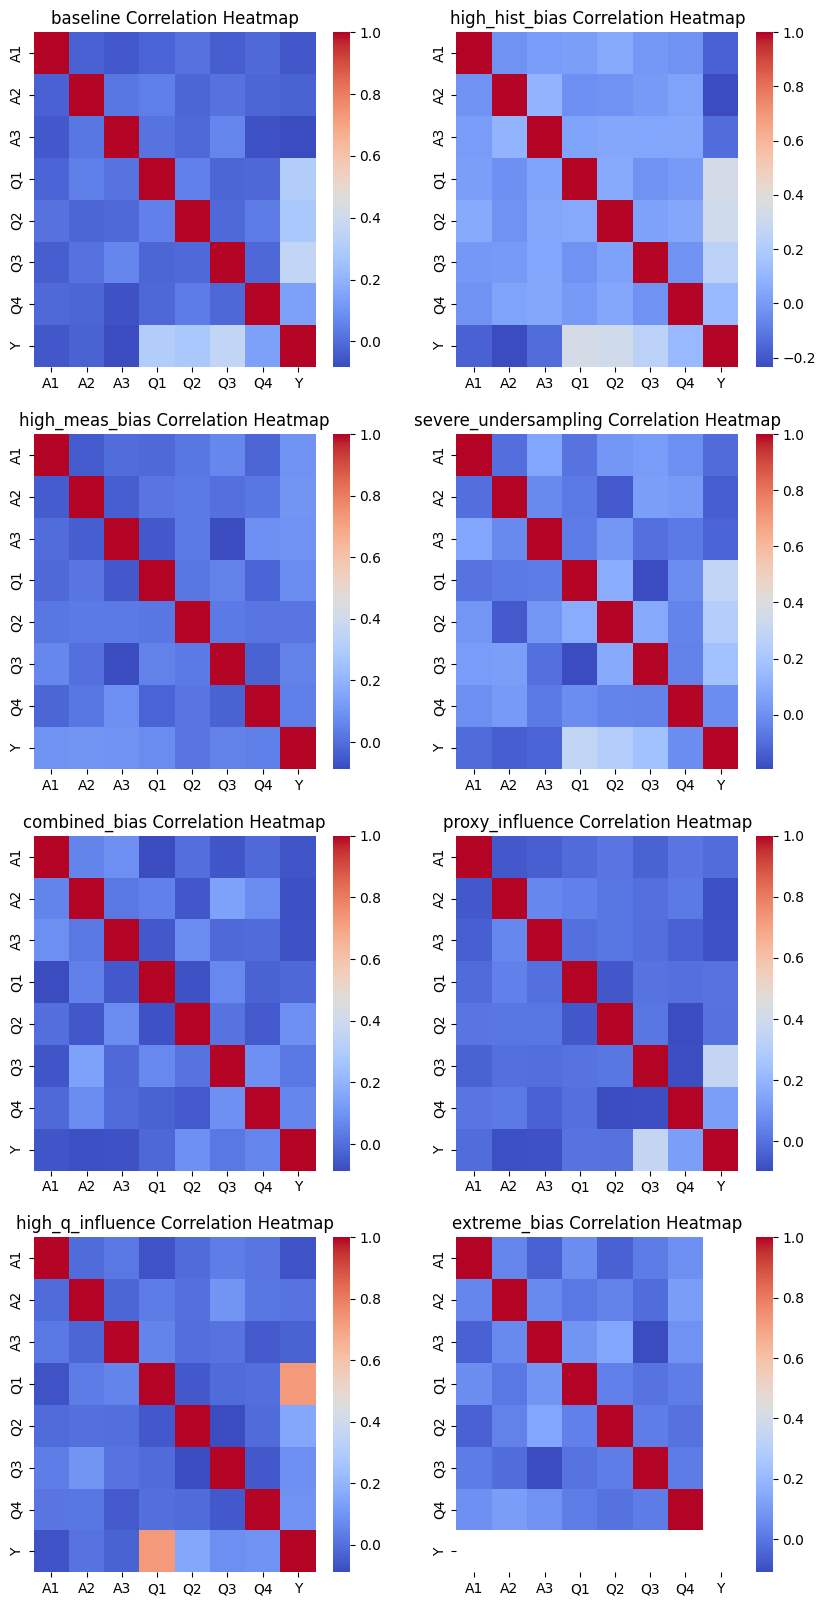

In [7]:
fig, axs = plt.subplots(4, 2, figsize=(10, 20))
axs = axs.flatten()

for i, setting_name in enumerate(bias_analysis_results.keys()):
    corr = bias_analysis_results[setting_name]['correlation_heatmap']

    sns.heatmap(corr, ax=axs[i], cmap='coolwarm')
    axs[i].set_title(f'{setting_name} Correlation Heatmap')

plt.show()

In [8]:
# fig, axs = plt.subplots(4, 2, figsize=(10, 20))
# axs = axs.flatten()

# for i, setting_name in enumerate(bias_analysis_results.keys()):
#     cm = bias_analysis_results[setting_name]['confusion_matrix']

#     cmd = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
#     cmd.plot(ax=axs[i])
#     axs[i].set_title(f'{setting_name} Confusion Matrix')

# plt.show()


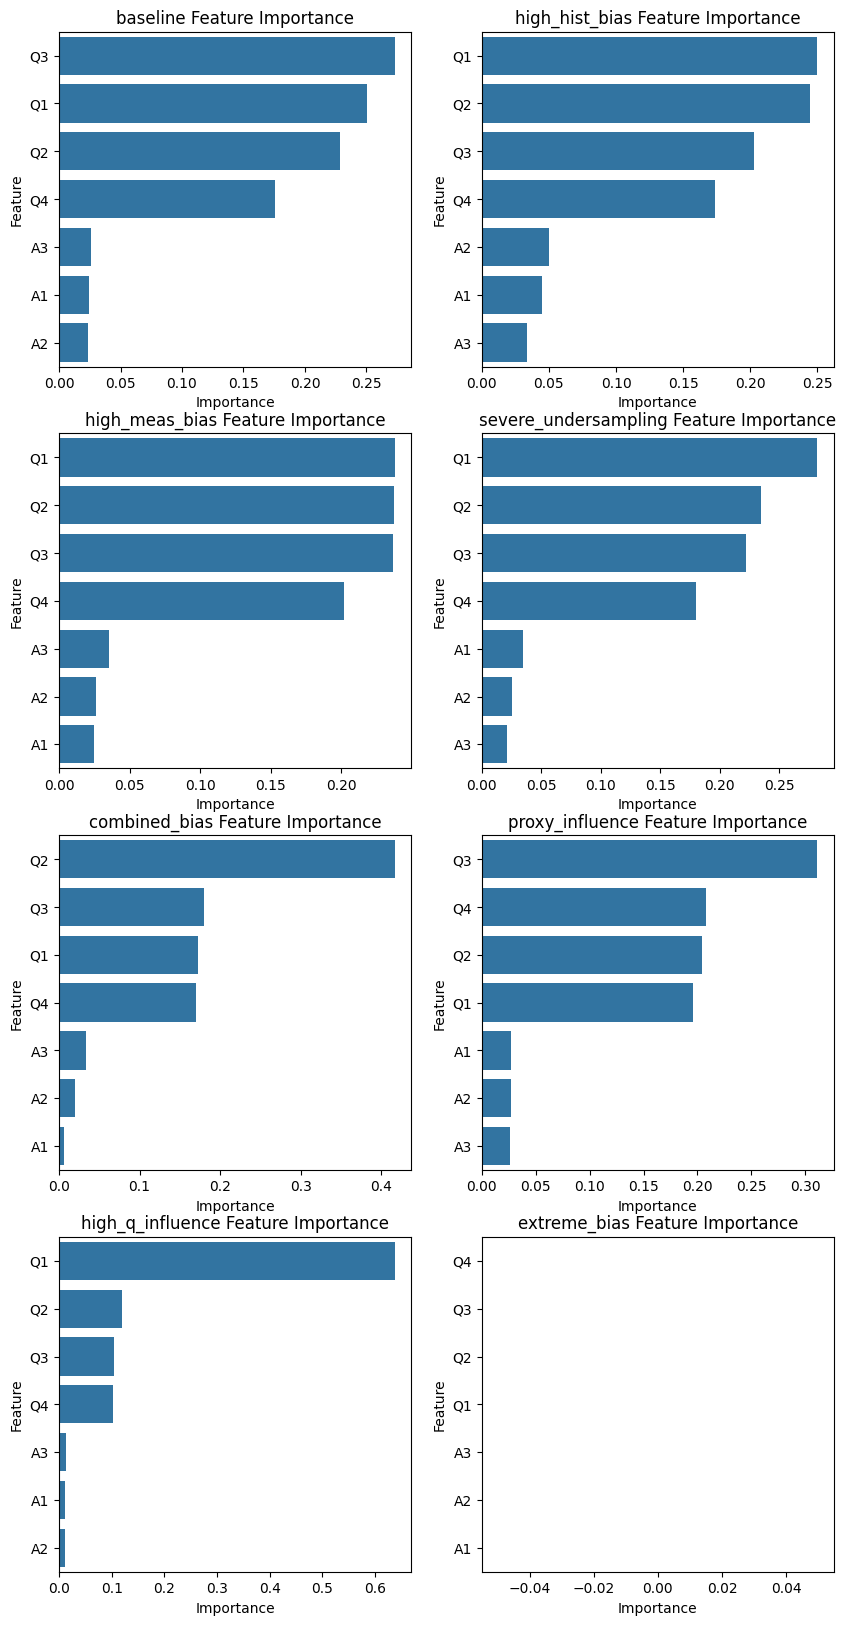

In [9]:
fig, axs = plt.subplots(4, 2, figsize=(10, 20))
axs = axs.flatten()

for i, setting_name in enumerate(bias_analysis_results.keys()):
    feature_importance_df = bias_analysis_results[setting_name]['feature_importance']

    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, ax=axs[i])
    axs[i].set_title(f'{setting_name} Feature Importance')

plt.show()

## Fairness Metrics

Explicação Demographic Parity

In [10]:
def demographic_parity(y_pred, protected_values):
    group_parity = {}
    for group in np.unique(protected_values):
        group_idx = protected_values == group
        group_parity[group] = np.mean(y_pred[group_idx])
    return group_parity

Explicação Equal Opportunity

In [11]:
def equal_opportunity(y_true, y_pred, protected_values):
    tpr = {}
    for group in np.unique(protected_values):
        group_idx = protected_values == group
        y_true_group = y_true[group_idx]
        y_pred_group = y_pred[group_idx]
        cm = confusion_matrix(y_true_group, y_pred_group)
        tpr[group] = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0
    return tpr

Explicação Equalized Odds

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def equalized_odds(y_true, y_pred, protected_values):
    eqo = {}
    for group in np.unique(protected_values):
        group_idx = protected_values == group
        group_y_true = y_true[group_idx]
        group_y_pred = y_pred[group_idx]
        mae = mean_absolute_error(group_y_true, group_y_pred)
        mse = mean_squared_error(group_y_true, group_y_pred)
        eqo[group] = {'MAE': mae, 'MSE': mse}
    return eqo

In [13]:
fairness_results = {}
protected_attribute = 'A1'

In [14]:
for setting_name in datasets.keys():
    y_test = datasets[setting_name]['y_test']
    x_test = datasets[setting_name]['X_test']
    y_train = datasets[setting_name]['y_train']
    x_train = datasets[setting_name]['X_train']

    clf = RandomForestClassifier(random_state=42)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    if protected_attribute in x_test.columns:
        protected_values = x_test[protected_attribute]

        dp = demographic_parity(y_pred, protected_values)
        #eo = equal_opportunity(y_test.values, y_pred, protected_values)
        eq = equalized_odds(y_test.values, y_pred, protected_values)

        fairness_results[setting_name] = {
            'DP': dp,
            #'EO': eo,
            'EQ': eq,
        }

        # Calculate group fairness metrics
        group_metrics = {}

        groups = x_test[protected_attribute].unique()

        for group in groups:
            group_idx = x_test[protected_attribute] == group
            group_y_test = y_test[group_idx]
            group_y_pred = y_pred[group_idx]

            group_metrics[group] = {
                'MAE': mean_absolute_error(group_y_test, group_y_pred),
                'MSE': mean_squared_error(group_y_test, group_y_pred),
                'R2': clf.score(x_test, y_test),
            }

        fairness_results[setting_name]['Group Metrics'] = group_metrics

In [15]:
for setting_name in fairness_results.keys():
    print(f'{setting_name} Fairness Results:')
    print('Demographic Parity:')
    print(fairness_results[setting_name]['DP'])
    #print('Equal Opportunity:')
    #print(fairness_results[setting_name]['EO'])
    print('Equalized Odds:')
    print(fairness_results[setting_name]['EQ'])
    print('Group Metrics:')
    for group in fairness_results[setting_name]['Group Metrics'].keys():
        print(f'{group}:')
        print(fairness_results[setting_name]['Group Metrics'][group])
    print('\n')

baseline Fairness Results:
Demographic Parity:
{0: 0.38461538461538464, 1: 0.2670807453416149}
Equalized Odds:
{0: {'MAE': 0.3076923076923077, 'MSE': 0.3076923076923077}, 1: {'MAE': 0.2732919254658385, 'MSE': 0.2732919254658385}}
Group Metrics:
0:
{'MAE': 0.3076923076923077, 'MSE': 0.3076923076923077, 'R2': 0.7090909090909091}
1:
{'MAE': 0.2732919254658385, 'MSE': 0.2732919254658385, 'R2': 0.7090909090909091}


high_hist_bias Fairness Results:
Demographic Parity:
{0: 0.6428571428571429, 1: 0.4382716049382716}
Equalized Odds:
{0: {'MAE': 0.2857142857142857, 'MSE': 0.2857142857142857}, 1: {'MAE': 0.24691358024691357, 'MSE': 0.24691358024691357}}
Group Metrics:
0:
{'MAE': 0.2857142857142857, 'MSE': 0.2857142857142857, 'R2': 0.7333333333333333}
1:
{'MAE': 0.24691358024691357, 'MSE': 0.24691358024691357, 'R2': 0.7333333333333333}


high_meas_bias Fairness Results:
Demographic Parity:
{0: 0.0, 1: 0.0}
Equalized Odds:
{0: {'MAE': 0.0, 'MSE': 0.0}, 1: {'MAE': 0.018404907975460124, 'MSE': 0.018

In [16]:
from aequitas import Audit

audit_results = {}

for setting_name in datasets.keys():
    y_test = datasets[setting_name]['y_test']
    x_test = datasets[setting_name]['X_test']
    y_train = datasets[setting_name]['y_train']
    x_train = datasets[setting_name]['X_train']

    # make columns A categorical (convert 1 to A and 0 to B)
    x_train['A1'] = x_train['A1'].map({1: 'A', 0: 'B'})
    x_train['A2'] = x_train['A2'].map({1: 'A', 0: 'B'})
    x_train['A3'] = x_train['A3'].map({1: 'A', 0: 'B'})
    x_test['A1'] = x_test['A1'].map({1: 'A', 0: 'B'})
    x_test['A2'] = x_test['A2'].map({1: 'A', 0: 'B'})
    x_test['A3'] = x_test['A3'].map({1: 'A', 0: 'B'})

    x_train['A1'] = x_train['A1'].astype('object')
    x_train['A2'] = x_train['A2'].astype('object')
    x_train['A3'] = x_train['A3'].astype('object')
    x_test['A1'] = x_test['A1'].astype('object')
    x_test['A2'] = x_test['A2'].astype('object')
    x_test['A3'] = x_test['A3'].astype('object')

    df = pd.concat([x_test, y_test], axis=1)
    audit = Audit(df, score_column='Y', sensitive_attribute_column=['A1','A2','A3'], label_column='Y')

    audit_results[setting_name] = audit

In [18]:
audit_baseline = audit_results['baseline']
audit_high_hist_bias = audit_results['high_hist_bias']
audit_high_meas_bias = audit_results['high_meas_bias']
audit_severe_undersampling = audit_results['severe_undersampling']
audit_combined_bias = audit_results['combined_bias']
audit_proxy_influence = audit_results['proxy_influence']
audit_high_q_influence = audit_results['high_q_influence']
audit_extreme_bias = audit_results['extreme_bias']

In [19]:
audit_baseline.summary_plot(["tpr", "fpr", "pprev"])

alt.VConcatChart(...)

In [20]:
audit_high_hist_bias.summary_plot(["tpr", "fpr", "pprev"])

alt.VConcatChart(...)

In [21]:
audit_high_meas_bias.summary_plot(["tpr", "fpr", "pprev"])

alt.VConcatChart(...)

In [22]:
audit_severe_undersampling.summary_plot(["tpr", "fpr", "pprev"])

alt.VConcatChart(...)

In [23]:
audit_combined_bias.summary_plot(["tpr", "fpr", "pprev"])

alt.VConcatChart(...)

In [24]:
audit_high_q_influence.summary_plot(["tpr", "fpr", "pprev"])

alt.VConcatChart(...)

## References

**Baumann, Joachim**, **Castelnovo, Alessandro**, **Crupi, Riccardo**, **Inverardi, Nicole**, and **Regoli, Daniele**. 2023. **Bias on Demand: A Modelling Framework That Generates Synthetic Data With Bias**. *In Proceedings of the 2023 ACM Conference on Fairness, Accountability, and Transparency*. [https://doi.org/10.1145/3593013.3594058](https://doi.org/10.1145/3593013.3594058).
